# Exploring the gliders ERDDAP server

In [1]:
from erddapy import ERDDAP


e = ERDDAP(
    server='https://data.ioos.us/gliders/erddap',
    protocol='tabledap',
)

### Define filter criteria:

Using the erddapy library to query the IOOS Glider DAC ERDDAP server, we'll look for CF standard name 'sea_water_temperature' with a bounding box covering roughly the Gulf of Mexico year 2018.  Also, filter by CDM data type of 'trajectoryprofile'.


In [2]:
min_lat, max_lat = 20, 30
min_lon, max_lon = -82, -97
        
kw = {
    'standard_name': 'sea_water_temperature',
    'min_lon': min_lon,
    'max_lon': max_lon,
    'min_lat': min_lat,
    'max_lat': max_lat,
    'min_time': '2018-01-10T00:00:00Z',
    'max_time': '2018-09-01T00:00:00Z',
    'cdm_data_type': 'trajectoryprofile'
}

erddapy generates an ERDDAP 'advanced' search-compliant search url for us automatically (preview results using the link below):

In [3]:
search_url = e.get_search_url(response='csv', **kw)

print('search_url: ' + search_url)

search_url: https://data.ioos.us/gliders/erddap/search/advanced.csv?page=1&itemsPerPage=1000&protocol=(ANY)&cdm_data_type=trajectoryprofile&institution=(ANY)&ioos_category=(ANY)&keywords=(ANY)&long_name=(ANY)&standard_name=sea_water_temperature&variableName=(ANY)&minLon=-82&maxLon=-97&minLat=20&maxLat=30&minTime=1515542400.0&maxTime=1535760000.0


### Pandas integration:

Interrogate the search results using a Pandas DataFrame created from ERDDAP's csv output format:

In [4]:
import pandas as pd

search = pd.read_csv(search_url)
gliders = search['Dataset ID'].values

print('Found {} Glider Datasets:\n{}'.format(len(gliders), '\n'.join(gliders)))

Found 18 Glider Datasets:
allgcoos_dmacGliders
allrutgersGliders
allsecooraGliders
ng290-20180701T0000
ng295-20180701T0000
ng309-20180701T0000
ng342-20180701T0000
ng429-20180701T0000
ng448-20180701T0000
ng450-20180701T0000
ng464-20180701T0000
ng466-20180701T0000
ng489-20180701T0000
ng512-20180701T0000
ng596-20180701T0000
Reveille-20180627T1500
sam-20180824T0000
Sverdrup-20180509T1742


Check the `info` URL for a particular dataset.

In [5]:
dataset_id = 'sam-20180824T0000'

info_url = e.get_info_url(dataset_id=dataset_id, response='csv')
info = pd.read_csv(info_url)

info.head()

,Row Type,Variable Name,Attribute Name,Data Type,Value
0,attribute,NC_GLOBAL,acknowledgement,String,This work was supported by funding from The St...
1,attribute,NC_GLOBAL,cdm_data_type,String,TrajectoryProfile
2,attribute,NC_GLOBAL,cdm_profile_variables,String,"profile_id, time, latitude, longitude, time_uv..."
3,attribute,NC_GLOBAL,cdm_trajectory_variables,String,"trajectory, wmo_id"
4,attribute,NC_GLOBAL,contributor_name,String,"Chad Lembke, Robert Weisberg"


In [6]:
info.loc[info['Attribute Name'] == 'standard_name', 'Value']

77                                  time
92                              latitude
117                            longitude
156                                depth
182                   sea_water_pressure
206    sea_water_electrical_conductivity
230                    sea_water_density
258                             latitude
277                            longitude
290                                 time
340         sea_water_practical_salinity
364                sea_water_temperature
384                                 time
406                             latitude
429                            longitude
453          eastward_sea_water_velocity
477         northward_sea_water_velocity
Name: Value, dtype: object

 And select some of the variables of interest:

In [7]:
variables = [
 'depth',
 'latitude',
 'longitude',
 'salinity',
 'temperature',
 'time',
]

Assign these values to the ERRDAP server instance to download the glider deployment data!

Filipe, it would be a great addition to the erddapy library if there were a way to break down the query/download flow somehow so you could first interrogate a dataset's metadata (just the e.dataset_id = dataset_id) part, output metadata showing available variables, then apply a variable filter on a dataset object, rather than all the way up at the 'e' server level.  Such as:

```
e.dataset_id = dataset_id


dataset = e.get_dataset()
dataset                   #show variables, global attributes/other metadata
```
```
dataset.variables = variables

data = d.get_download_url(
        response='mat',  # like matlab? ERDDAP has your back!
    )
```
etc..

This may not be possible wrt ERDDAP's capabilities though, IDK.  Conceptually, that would make this much clearer and more intuitive though.  

In [8]:
e.dataset_id = dataset_id
e.variables = variables

print(
    e.get_download_url(
        response='mat',  # like matlab? ERDDAP has your back!
    )
)

https://data.ioos.us/gliders/erddap/tabledap/sam-20180824T0000.mat?depth,latitude,longitude,salinity,temperature,time


Clicking in the URL above will get a `.mat` file ready for download.
However, we'll stay in the Python world and use pandas to load a `csv`.

In [9]:
df = e.to_pandas(
    index_col='time',
    parse_dates=True,
    skiprows=(1,)
).dropna()

df.head()

,depth,latitude,longitude,salinity,temperature
time,,,,,
2018-08-24 22:28:56,2.771356,28.351149,-83.498135,34.554237,29.9049
2018-08-24 22:28:56,3.426940,28.351149,-83.498135,34.592440,29.8862
2018-08-24 22:28:56,4.469911,28.351149,-83.498135,34.635780,29.8539
2018-08-24 22:28:56,5.522809,28.351149,-83.498135,34.670925,29.8730
2018-08-24 22:28:56,6.357177,28.351149,-83.498135,34.725838,29.9482


### Plot a trajectoryProfile of water temperature using matplotlib



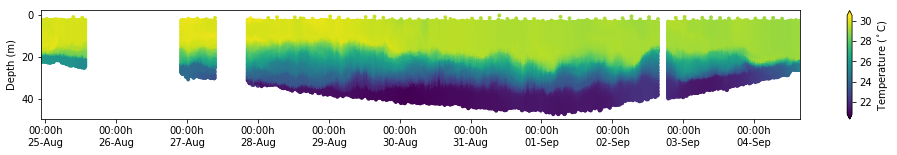

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

fig, ax = plt.subplots(figsize=(17, 2))
cs = ax.scatter(df.index, df['depth'], s=15, c=df['temperature'],
                marker='o', edgecolor='none')

ax.invert_yaxis()
ax.set_xlim(df.index[0], df.index[-1])
xfmt = mdates.DateFormatter('%H:%Mh\n%d-%b')
ax.xaxis.set_major_formatter(xfmt)

cbar = fig.colorbar(cs, orientation='vertical', extend='both')
cbar.ax.set_ylabel('Temperature ($^\circ$C)')
ax.set_ylabel('Depth (m)');

### Plot the glider track using CartoPY:

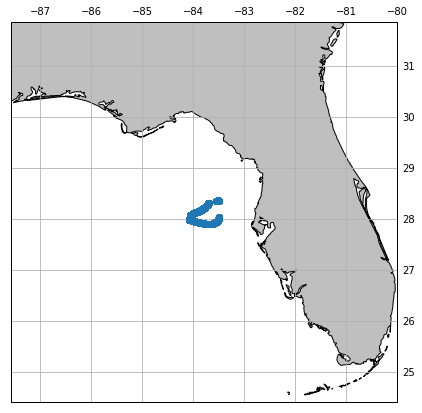

In [11]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature


land_10m = cfeature.NaturalEarthFeature(
    'physical', 'land', '10m',
     edgecolor='k', facecolor='0.75',
)


fig, ax = plt.subplots(
    subplot_kw={'projection': ccrs.PlateCarree()},
    figsize=(7, 7)
)

ax.plot(df['longitude'], df['latitude'], 'o')

gl = ax.gridlines(draw_labels=True)
gl.xlabels_bottom = gl.ylabels_left = False

ax.add_feature(land_10m)

dx = dy = 3.5
ax.set_extent(
    [df['longitude'].min()-dx, df['longitude'].max()+dx,
     df['latitude'].min()-dy, df['latitude'].max()+dy]
);